<a href="https://colab.research.google.com/github/lmichan/BIOliteraturaPE203625/blob/main/Enlace_con_Zotero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de la Biblioteca Zotero - Biología 2025

Este cuaderno de Google Colab fue desarrollado por José Antonio Hernández Mondragón como parte del proyecto PAPIME PE203625.

El propósito principal de este código es realizar un análisis detallado de la biblioteca Zotero correspondiente al curso de Biología 2025, con el fin de extraer información relevante, identificar patrones de uso, temáticas predominantes y apoyar la toma de decisiones en la gestión y mejora de los recursos bibliográficos disponibles.

A lo largo del cuaderno se implementan herramientas de procesamiento de datos, visualización y análisis bibliométrico para obtener una visión integral del contenido y estructura de la biblioteca Zotero.

## Conexión entre Zotero y Google Colab

Para realizar el análisis de la biblioteca de Zotero desde Google Colab, es necesario establecer una conexión entre ambas plataformas utilizando la Zotero Web API. Esta API permite acceder a colecciones, referencias, metadatos y otros recursos almacenados en una cuenta o grupo de Zotero, lo cual facilita el procesamiento automatizado de los datos.

## Requisitos de configuración

Antes de comenzar el análisis, es necesario contar con dos elementos clave:

* Zotero API Key

* Group ID (en caso de trabajar con una biblioteca de grupo)

### 1. Zotero API Key

La API Key es una clave personal que otorga permisos para acceder a la biblioteca Zotero de forma segura. Para obtenerla, sigue estos pasos:

* Accede a tu cuenta en Zotero.org.

* Ve a Settings > Feeds/API.

* En la sección de API Keys, haz clic en Create new private key.

* Define los permisos de acceso (por ejemplo, lectura) y copia la clave generada.

* Esta clave se utilizará en el código para autenticar las solicitudes a la API.

### 2. Group ID

Si estás trabajando con una biblioteca de grupo, también necesitas el identificador único del grupo. Para obtenerlo:

* Ingresa al sitio de Zotero y selecciona tu grupo.

* El Group ID se encuentra en la URL del grupo. Por ejemplo, en: https://www.zotero.org/groups/1234567/nombre_del_grupo

* El número 1234567 es el Group ID que deberás usar.


In [1]:
# @title
# CONFIGURA TU CLAVE Y GROUP ID

import requests
from collections import defaultdict, Counter
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

# CONFIGURA TU CLAVE Y GROUP ID (Estos se obtienen en Zotero)
API_KEY = "l7nkDwrKLxASVprKSjbadbXs"
GROUP_ID = "5866354"
HEADERS = {"Zotero-API-Key": API_KEY}


In [2]:
# @title
# FUNCION PARA OBTENER ITEMS DEL GRUPO
def fetch_all_items(group_id):
    items = []
    start = 0
    limit = 100
    while True:
        url = f"https://api.zotero.org/groups/{group_id}/items?limit={limit}&start={start}"
        resp = requests.get(url, headers=HEADERS)
        if resp.status_code != 200:
            print("Error al obtener ítems:", resp.status_code)
            break
        batch = resp.json()
        if not batch:
            break
        items.extend(batch)
        start += limit
    return items

items = fetch_all_items(GROUP_ID)


# ANALISIS: usuario + fecha de subida
data_por_usuario = []
for item in items:
    fecha_str = item.get("data", {}).get("dateAdded", "")
    user = item.get("meta", {}).get("lastModifiedByUser", {}).get("username")  # o simplemente str(user_id)

    if fecha_str and user:
        try:
            fecha = datetime.fromisoformat(fecha_str.split("T")[0])
            data_por_usuario.append({"usuario": user, "fecha": fecha})
        except Exception as e:
            print("Error de fecha:", fecha_str, e)

# Verificar si hay datos
if not data_por_usuario:
    raise ValueError("No se encontraron datos con usuario y fecha.")

# Convertir a DataFrame
df = pd.DataFrame(data_por_usuario)

# ✅ Verifica que las columnas existen
print("Columnas del DataFrame:", df.columns.tolist())
print(df.head())

# Agrupar por fecha y usuario
conteo = df.groupby([df["fecha"].dt.date, "usuario"]).size().reset_index(name="total")



Columnas del DataFrame: ['usuario', 'fecha']
       usuario      fecha
0  lizethmunoz 2025-03-31
1  lizethmunoz 2025-05-27
2  lizethmunoz 2025-02-11
3  lizethmunoz 2025-05-28
4  lizethmunoz 2025-03-04


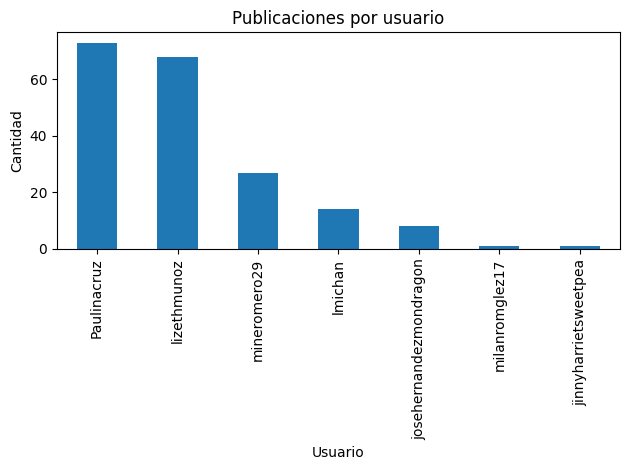

In [3]:
# @title
# ------------------------
# 📊 Gráfico 1: Publicaciones por usuario (total)
usuarios = df["usuario"].value_counts()
usuarios.plot(kind="bar", title="Publicaciones por usuario", ylabel="Cantidad", xlabel="Usuario")
plt.tight_layout()
plt.show()

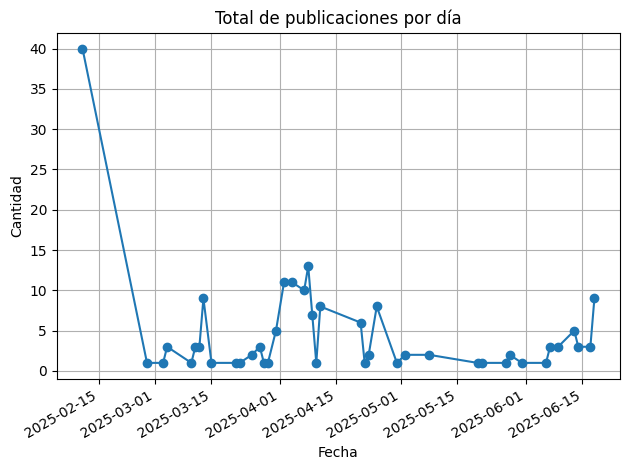

In [4]:
# ------------------------
# 📊 Gráfico 2: Publicaciones por día


df_por_dia = df.groupby("fecha").size()
df_por_dia.plot(kind="line", marker="o", title="Total de publicaciones por día")
plt.ylabel("Cantidad")
plt.xlabel("Fecha")
plt.grid(True)
plt.tight_layout()
plt.show()

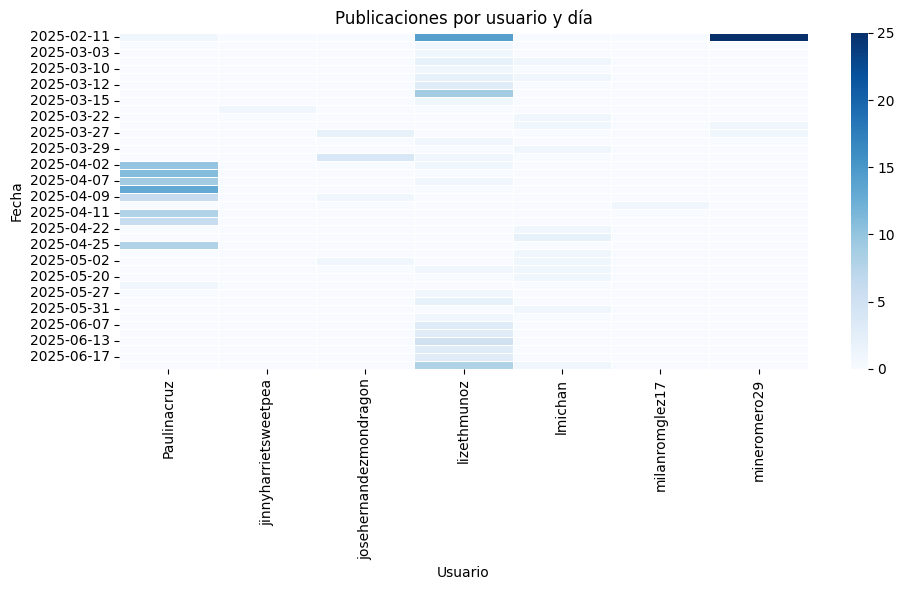

In [5]:
# ------------------------
# 📊 Gráfico 3: Heatmap usuario vs fecha
pivot = conteo.pivot(index="fecha", columns="usuario", values="total").fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="Blues", linewidths=0.5)
plt.title("Publicaciones por usuario y día")
plt.xlabel("Usuario")
plt.ylabel("Fecha")
plt.tight_layout()
plt.show()

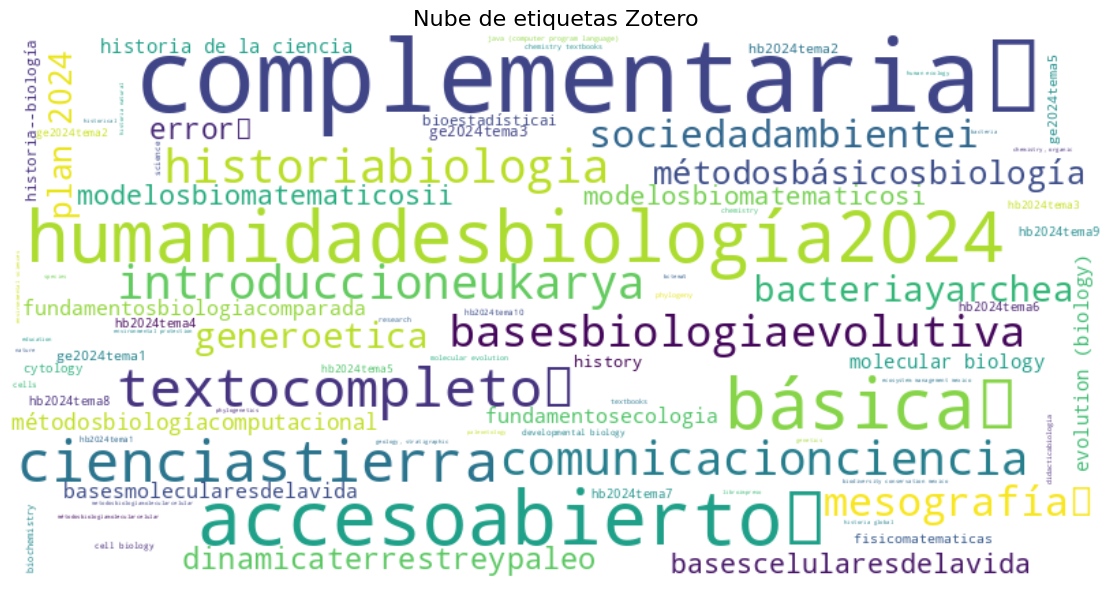

In [6]:
# Extraer etiquetas
etiquetas = []
for item in items:
    tags = item.get('data', {}).get('tags', [])
    for tag in tags:
        etiquetas.append(tag['tag'].lower())  # homogenizar a minúsculas

# Contar frecuencia
conteo = Counter(etiquetas)

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(conteo)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de etiquetas Zotero", fontsize=16)
plt.tight_layout()
plt.show()


Etiquetas más frecuentes:
complementaria🟢: 427
accesoabierto🆓: 205
humanidadesbiología2024: 188
básica🔵: 180
cienciastierra: 120
textocompleto🔺​: 107
historiabiologia: 75
introduccioneukarya: 74
comunicacionciencia: 72
basesbiologiaevolutiva: 65
mesografía🟡: 57
sociedadambientei: 49
generoetica: 41
bacteriayarchea: 41
métodosbásicosbiología: 37
plan 2024: 35
dinamicaterrestreypaleo: 34
error❌: 32
basescelularesdelavida: 30
modelosbiomatematicosii: 29


/tmp/ipython-input-1302488449.py:22: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1302488449.py:22: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1302488449.py:22: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1302488449.py:22: UserWarning: Glyph 127379 (\N{SQUARED FREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1302488449.py:22: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: 

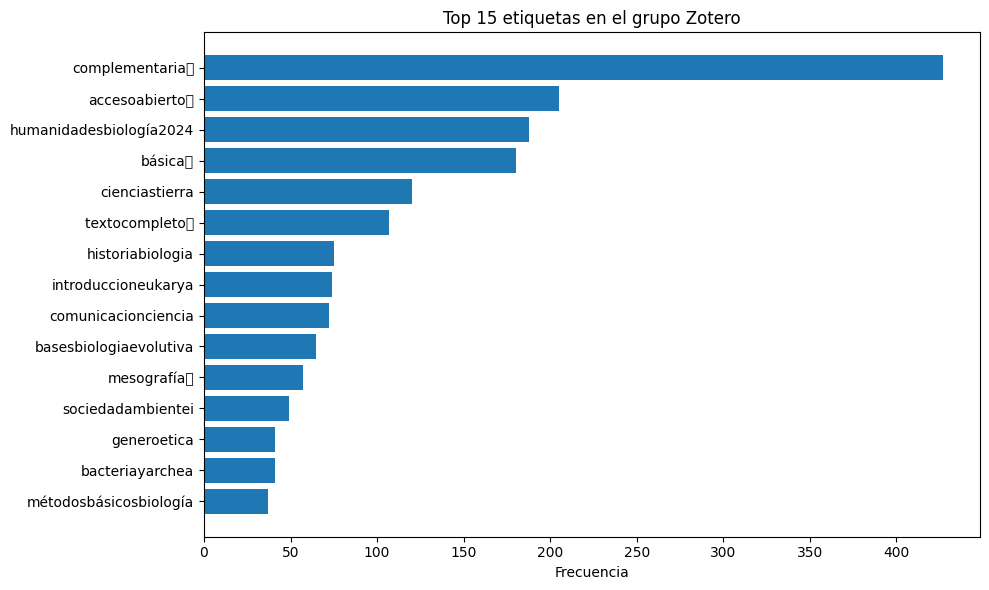

In [7]:
# Extraer todas las etiquetas
etiquetas = []
for item in items:
    tags = item.get('data', {}).get('tags', [])
    for tag in tags:
        etiquetas.append(tag['tag'].lower())  # lo pasamos a minúsculas para agrupar mejor

# Contar frecuencia de cada etiqueta
conteo_etiquetas = Counter(etiquetas)

# Mostrar etiquetas y sus frecuencias
print("\nEtiquetas más frecuentes:")
for etiqueta, count in conteo_etiquetas.most_common(20):  # top 20
    print(f"{etiqueta}: {count}")

# Visualización
plt.figure(figsize=(10, 6))
labels, values = zip(*conteo_etiquetas.most_common(15))
plt.barh(labels[::-1], values[::-1])
plt.title("Top 15 etiquetas en el grupo Zotero")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!pip install --upgrade gspread oauth2client

In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# Configura los scopes para acceder a Google Sheets y Drive
scope = [
    "https://spreadsheets.google.com/feeds",
    "https://www.googleapis.com/auth/drive"
]

# Reemplaza con el nombre exacto del archivo que subiste
credenciales = ServiceAccountCredentials.from_json_keyfile_name("biolaboratorio-468502-b5819cec4d98.json", scope)

# Autentica
client = gspread.authorize(credenciales)

# Prueba abrir una hoja (usa el nombre exacto)
sheet = client.open_by_key("1gkPjkIySucnrnxdmJPO1TZM4-NXFRsB0rM_kpUb80Ww").sheet1

# Prueba escribir algo
sheet.update_cell(1, 1, "¡Funciona en Colab!")

print("✅ ¡Conectado correctamente a Google Sheets!")


In [ ]:
# Crea o abre tu hoja
spreadsheet = client.open_by_key("1gkPjkIySucnrnxdmJPO1TZM4-NXFRsB0rM_kpUb80Ww")

# Función para cargar un DataFrame a una pestaña nueva
def cargar_df(df, nombre_hoja):
    try:
        spreadsheet.del_worksheet(spreadsheet.worksheet(nombre_hoja))
    except:
        pass
    sheet = spreadsheet.add_worksheet(title=nombre_hoja, rows=str(len(df)+10), cols=str(len(df.columns)+10))
    sheet.update([df.columns.values.tolist()] + df.values.tolist())
    print(f"✅ Datos cargados en la hoja: {nombre_hoja}")

# --------------------------------
# 1. Etiquetas y frecuencia
from collections import Counter
conteo_etiquetas = Counter(etiquetas)  # del análisis previo
df_etiquetas = pd.DataFrame(conteo_etiquetas.items(), columns=["Etiqueta", "Frecuencia"])
cargar_df(df_etiquetas, "Etiquetas")

# --------------------------------
# 2. Publicaciones por usuario
df_usuarios = df.groupby("usuario").size().reset_index(name="Total_Publicaciones")
cargar_df(df_usuarios, "PorUsuario")

# --------------------------------
# 3. Publicaciones por fecha
df_por_fecha = df.groupby(df["fecha"].dt.date).size().reset_index(name="Total_Publicaciones")
df_por_fecha["fecha"] = df_por_fecha["fecha"].astype(str)
cargar_df(df_por_fecha, "PorFecha")

# --------------------------------
# 4. Publicaciones por usuario y fecha
conteo = df.groupby([df["fecha"].dt.date, "usuario"]).size().reset_index(name="Total")
conteo = df.groupby([df["fecha"].dt.date, "usuario"]).size().reset_index(name="Total")

# ✅ Convertir columna de fechas a string
conteo["fecha"] = conteo["fecha"].astype(str)

# ✅ Subir al Sheet
cargar_df(conteo, "UsuarioFecha")

print("🎉 Todos los datos exportados a Google Sheets correctamente.")


In [ ]:
# CONFIGURA TU CLAVE Y GROUP ID (Estos se obtienen en Zotero)
API_KEY = "l7nkDwrKLxASVprKSjbadbXs"
group_id = "5866354"
headers = {"Zotero-API-Key": API_KEY}


# Descargar ítems (paginado si es necesario)
items = []
start = 0
limit = 100

while True:
    url = f"https://api.zotero.org/groups/{group_id}/items?limit={limit}&start={start}"
    response = requests.get(url, headers=headers)
    data = response.json()

    if not data:
        break

    for item in data:
        if "data" in item:
            items.append({
                "titulo": item["data"].get("title"),
                "fecha": item["data"].get("dateAdded")
            })

    start += limit


df = pd.DataFrame(items)
df["fecha"] = pd.to_datetime(df["fecha"])

# Agrupar por día
conteo_por_dia = df.groupby(df["fecha"].dt.date).size().reset_index(name="Total_Publicaciones")

# Opcional: convertir fechas a string para exportar
conteo_por_dia["fecha"] = conteo_por_dia["fecha"].astype(str)

# Ver resultados
print(conteo_por_dia.head())

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(conteo_por_dia["fecha"], conteo_por_dia["Total_Publicaciones"], marker='o')
plt.xticks(rotation=45)
plt.title("Publicaciones añadidas por día")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que ya tienes el DataFrame `df` con una columna "fecha"
# Asegúrate de que sea datetime
df["fecha"] = pd.to_datetime(df["fecha"])

# 🔹 Agrupar por semana (esto crea objetos tipo "2025-08-04/2025-08-10")
df["semana"] = df["fecha"].dt.to_period("W").apply(lambda r: r.start_time)

# 🔹 Contar publicaciones por semana
conteo_semanal = df.groupby("semana").size().reset_index(name="Total_Publicaciones")

# 🔹 Convertir fechas para graficar o exportar
conteo_semanal["semana"] = conteo_semanal["semana"].dt.strftime("%Y-%m-%d")

# ✅ Ver resultado
print(conteo_semanal.head())

plt.figure(figsize=(10, 5))
plt.plot(conteo_semanal["semana"], conteo_semanal["Total_Publicaciones"], marker='o')
plt.xticks(rotation=45)
plt.title("Publicaciones añadidas por semana")
plt.xlabel("Semana")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
items = []
start = 0
limit = 100  # Zotero limita a 100 ítems por solicitud

while True:
    url = f"https://api.zotero.org/groups/{group_id}/items?limit={limit}&start={start}"
    response = requests.get(url, headers=headers)
    data = response.json()

    if not data:
        break

    for item in data:
        d = item["data"]
        items.append({
            "titulo": d.get("title"),
            "tipo": d.get("itemType"),
            "fecha": pd.to_datetime(d.get("dateAdded"), errors="coerce"),
            "doi": d.get("DOI") or d.get("doi"),  # Algunos lo escriben en mayúsculas
            "url": d.get("url")
        })

    start += limit

# Crear DataFrame
df = pd.DataFrame(items)
print(f"✅ Total de ítems descargados: {len(df)}")
df.head()

conteo_tipo = df["tipo"].value_counts().reset_index()
conteo_tipo.columns = ["Tipo de ítem", "Cantidad"]
conteo_tipo

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(conteo_tipo["Tipo de ítem"], conteo_tipo["Cantidad"], color="skyblue")
plt.xticks(rotation=45, ha='right')
plt.title("📚 Publicaciones por tipo de ítem en Zotero")
plt.xlabel("Tipo de ítem")
plt.ylabel("Cantidad")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# Filtramos registros con DOI no nulo y no vacío
con_doi = df["doi"].notnull() & df["doi"].astype(str).str.strip().ne("")

# Conteo
total_con_doi = con_doi.sum()
total_total = len(df)
porcentaje = (total_con_doi / total_total) * 100

print(f"🔍 Publicaciones con DOI: {total_con_doi}")
print(f"📦 Total de publicaciones: {total_total}")
print(f"📊 Porcentaje con DOI: {porcentaje:.2f}%")


In [ ]:
# Verificamos si la columna existe y no está vacía
con_url = df["url"].notnull() & df["url"].astype(str).str.strip().ne("")

# Conteos
total_con_url = con_url.sum()
total_total = len(df)
porcentaje = (total_con_url / total_total) * 100

print(f"🌐 Publicaciones con URL: {total_con_url}")
print(f"📦 Total de publicaciones: {total_total}")
print(f"📊 Porcentaje con URL: {porcentaje:.2f}%")


In [ ]:
# Publicaciones que tienen DOI o URL
con_doi = df["doi"].notnull() & df["doi"].astype(str).str.strip().ne("")
con_url = df["url"].notnull() & df["url"].astype(str).str.strip().ne("")

ambos = df[con_doi & con_url]
solo_doi = df[con_doi & ~con_url]
solo_url = df[con_url & ~con_doi]
ninguno = df[~con_doi & ~con_url]

print(f"✅ Con ambos: {len(ambos)}")
print(f"📄 Solo DOI: {len(solo_doi)}")
print(f"🔗 Solo URL: {len(solo_url)}")
print(f"❌ Sin DOI ni URL: {len(ninguno)}")


In [ ]:
!pip install pyspellchecker

import pandas as pd
import re
from spellchecker import SpellChecker

# Cargamos tus datos (asegúrate de tener df['titulo'])
spell = SpellChecker(language='es')

# Lista para almacenar títulos con problemas
problemas = []

# Recorremos los títulos
for titulo in df["titulo"].dropna():
    errores = []

    # 1. Palabras en mayúsculas (completamente)
    if any(word.isupper() and len(word) > 1 for word in titulo.split()):
        errores.append("MAYÚSCULAS")

    # 2. Punto final
    if titulo.strip().endswith("."):
        errores.append("PUNTO FINAL")

    # 3. Espacios dobles
    if "  " in titulo:
        errores.append("ESPACIOS DOBLES")

    # 4. Guiones
    if "-" in titulo:
        errores.append("GUIONES")

    # 5. Corchetes
    if "[" in titulo or "]" in titulo:
        errores.append("CORCHETES")

    # 6. Símbolos especiales
    if re.search(r"[@#\$%\^&\*\~\=]", titulo):
        errores.append("SÍMBOLOS ESPECIALES")

    # 7. Faltas de ortografía
    palabras = re.findall(r'\b\w+\b', titulo.lower())
    errores_ort = spell.unknown(palabras)

    if errores_ort and len(errores_ort) >= 2:  # tolerancia: al menos 2 palabras mal
        errores.append("ORTOGRAFÍA")

    # Guardamos si hay al menos un error
    if errores:
        problemas.append({"titulo": titulo, "errores": ", ".join(errores)})

# Convertimos en DataFrame
df_errores = pd.DataFrame(problemas)
print(f"🔎 Títulos problemáticos encontrados: {len(df_errores)}")
df_errores.head(10)


In [ ]:
import requests
import pandas as pd
import re

items = []
start = 0
limit = 100

while True:
    url = f"https://api.zotero.org/groups/{group_id}/items?limit={limit}&start={start}"
    response = requests.get(url, headers=headers)
    data = response.json()

    if not data:
        break

    for item in data:
        d = item["data"]
        date_raw = d.get("date", "")

        # Extraer año con regex (si existe un año de 4 dígitos)
        match = re.search(r"\b(1[89]\d{2}|20\d{2}|21\d{2})\b", date_raw)
        year = int(match.group(0)) if match else None

        items.append({
            "titulo": d.get("title"),
            "año": year,
            "tipo": d.get("itemType")
        })

    start += limit

# Crear DataFrame
df = pd.DataFrame(items)
print(f"✅ Total de ítems descargados: {len(df)}")
df.head()

conteo_por_anio = df["año"].value_counts().sort_index().reset_index()
conteo_por_anio.columns = ["Año", "Cantidad"]
conteo_por_anio = conteo_por_anio[conteo_por_anio["Año"].notnull()]  # Filtrar nulos
conteo_por_anio["Año"] = conteo_por_anio["Año"].astype(int)
conteo_por_anio

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(conteo_por_anio["Año"], conteo_por_anio["Cantidad"], color="mediumseagreen")
plt.title("📅 Publicaciones por año de publicación (Zotero)")
plt.xlabel("Año")
plt.ylabel("Cantidad de ítems")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [ ]:
from datetime import datetime

anio_actual = datetime.now().year

# Filtramos filas con año válido
df_validos = df[df["año"].notnull()]

# Calculamos edad de cada publicación
df_validos["edad"] = anio_actual - df_validos["año"]

# Vemos los primeros
df_validos.head()

edad_promedio = df_validos["edad"].mean()
print(f"La edad promedio de las publicaciones es de {edad_promedio:.2f} años.")

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df_validos["edad"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribución de la edad de las publicaciones")
plt.xlabel("Edad (años)")
plt.ylabel("Cantidad de publicaciones")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
